<a href="https://colab.research.google.com/github/Satwikram/Sign-Language-Prediction/blob/main/Sign%20Language%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Author: Satwik Ram K

### Connecting to Kaggle

In [1]:
from google.colab import files

files.upload()


! mkdir ~/.kaggle


! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d ahmedkhanak1995/sign-language-gesture-images-dataset

 97% 185M/191M [00:02<00:00, 78.8MB/s]
100% 191M/191M [00:02<00:00, 70.5MB/s]


### Unzipping the dataset

In [ ]:
! unzip /content/sign-language-gesture-images-dataset.zip

### Importing Dependencies

In [1]:
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
import random

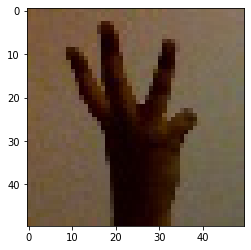

In [2]:
plt.imshow(plt.imread("/content/Gesture Image Data/6/1.jpg"))

### Load all the Images

In [3]:
uniq_labels = sorted(os.listdir('/content/Gesture Image Data'))

In [4]:
uniq_labels

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '_']

In [5]:
def load_dataset(directory):

  images = []
  labels = []

 
  for idx, label in tqdm(enumerate(uniq_labels)):
    for file in os.listdir(directory+label):
      filepath = directory+label+"/"+file
      img = cv2.resize(cv2.imread(filepath),(50,50))
      img = img /255
      
      images.append(img)
      labels.append(idx)

  images = np.asarray(images)
  labels = np.asarray(labels)
  return images, labels

### Loading Dataset

In [6]:
X, y = load_dataset('/content/Gesture Image Data/')

37it [00:35,  1.05it/s]


In [7]:
X.shape, y.shape

((55500, 50, 50, 3), (55500,))

In [8]:
y[1499]

0

### Converting to Categorical

In [9]:
y = tf.keras.utils.to_categorical(y, num_classes = len(uniq_labels))

In [10]:
y[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

### Splitting Data into train and test

In [11]:
len(X)*0.05

2775.0

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state = 388)

In [14]:
uniq_labels[np.argmax(y_test[200])]

'3'

### Checking

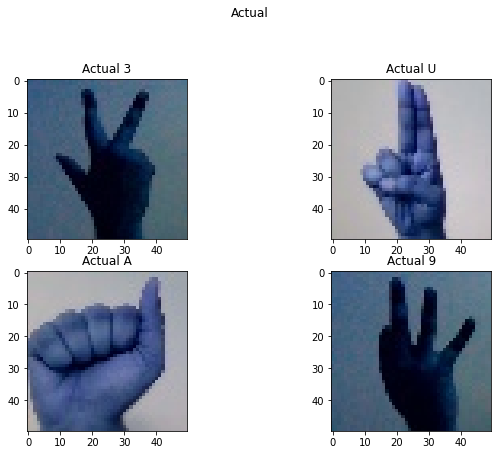

In [15]:
plt.figure(figsize = (10,10))
plt.subplot(3, 2, 1)
plt.imshow(X_test[200])
plt.title("Actual " + str(uniq_labels[np.argmax(y_test[200])]))

plt.subplot(3, 2, 2)
plt.imshow(X_test[2000])
plt.title("Actual "+ str(uniq_labels[np.argmax(y_test[2000])]))

plt.subplot(3, 2, 3)
plt.imshow(X_test[300])
plt.title("Actual "+ str(uniq_labels[np.argmax(y_test[300])]))

plt.subplot(3, 2, 4)
plt.imshow(X_test[350])
plt.title("Actual "+ str(uniq_labels[np.argmax(y_test[350])]))

plt.suptitle("Actual")
plt.show()

### Model Building

In [66]:
def build_model():

  model = tf.keras.models.Sequential([
                                      
          tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (1, 1), 
                                 activation = 'relu', input_shape = (50, 50, 3)),

          tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (1, 1), 
                                 activation = 'relu'),
                            
          tf.keras.layers.BatchNormalization(),
          
          tf.keras.layers.MaxPool2D(pool_size = (2, 2)),

          tf.keras.layers.GlobalAveragePooling2D(),

          tf.keras.layers.Dense(units = 256, activation = 'relu'),

          tf.keras.layers.BatchNormalization(),

          tf.keras.layers.Dense(units = 37, activation = 'softmax')

        ])

  model.summary()

  print("Model Successfully Created!")

  return model

In [67]:
model = build_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1

### Compiling the model

In [82]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

### Loading Model

In [37]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Sign Language Prediction/model.h5')

### Creating Checkpoints and Callbacks

In [38]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Sign Language Prediction/model.h5',
                              monitor = 'val_loss',
                              save_best_only = True,
                              verbose = 1,
                              mode = 'min')

In [39]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.2,
                              patience = 2, min_lr = 0.001, verbose = 1)

In [40]:
def scheduler(epoch, lr):
  if epoch < 2:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [41]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

In [42]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0, 
                                             patience = 2, verbose = 1, mode='min',
                                             restore_best_weights = True)

### Custom Callbacks

In [43]:
class ModelAnalysis(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs = None):

    plt.figure(figsize = (20,20))

    a = random.randint(0, 2775)
    plt.subplot(3, 2, 1)
    plt.imshow(X_test[a])
    plt.title("Actual class " + str(uniq_labels[np.argmax(y_test[a])]))

    plt.subplot(3, 2, 2)
    plt.imshow(X_test[a])
    test0 = np.expand_dims(X_test[a], axis = 0)
    plt.title("Predicted class " + str(uniq_labels[np.argmax(loaded_model.predict(test0))]))

    b = random.randint(0, 2775)

    plt.subplot(3, 2, 3)
    plt.imshow(X_test[b])
    plt.title("Actual class " + str(uniq_labels[np.argmax(y_test[b])]))

    plt.subplot(3, 2, 4)
    plt.imshow(X_test[b])
    test1 = np.expand_dims(X_test[b], axis = 0)
    plt.title("Predicted class " + str(uniq_labels[np.argmax(loaded_model.predict(test1))]))

    c = random.randint(0, 2775)

    plt.subplot(3, 2, 5)
    plt.imshow(X_test[c])
    plt.title("Actual class " + str(uniq_labels[np.argmax(y_test[c])]))

    plt.subplot(3, 2, 6)
    plt.imshow(X_test[c])
    test2 = np.expand_dims(X_test[c], axis = 0)
    plt.title("Predicted class " + str(uniq_labels[np.argmax(loaded_model.predict(test2))]))


    plt.suptitle("Model Analysis at Epoch")
    plt.show()


In [44]:
ob = ModelAnalysis()

In [46]:
from livelossplot.tf_keras import PlotLossesCallback
from livelossplot import PlotLossesKeras

In [47]:
callbacks = [checkpoint, reduce_lr, lr_schedule, earlystop, PlotLossesKeras(), ob]

### Training the Model

In [ ]:
history = loaded_model.fit(X_train, y_train, epochs = 5, batch_size = 64, verbose = 1,
                    validation_data = (X_test, y_test), shuffle = True,
                    callbacks = callbacks)

Epoch 1/5

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
 47/824 [>.............................] - ETA: 11:51 - loss: 0.0028 - accuracy: 1.0000